In [1]:
import joblib
import pandas as pd
from engineering import EngineeringTransformer

import warnings
warnings.filterwarnings("ignore")

pipeline = joblib.load('../pipelines/feature_engineering_pipeline.joblib')
df = pd.read_csv("../data/train.csv")
df_val = pd.read_csv("../data/orig_valid.csv")
df_val = pipeline.transform(df_val)


# Testing models

In [2]:
y_train = df['FINALIZED_LOAN']
X_train = df.drop(columns="FINALIZED_LOAN")

y_val = df_val['FINALIZED_LOAN']
X_val = df_val.drop(columns="FINALIZED_LOAN")


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

def my_cross_validate(model, X_train, y_train, cv=6, n_jobs=-1, scoring="f1"):
    cv_results = cross_validate(model, X_train, y_train, cv=cv, n_jobs=n_jobs, scoring=scoring)
    base_results = cross_validate(DummyClassifier(strategy="uniform"), X_train, y_train, cv=cv, n_jobs=n_jobs, scoring=scoring)

    scores = [(name, cv_results[name]) for name in cv_results if name.startswith("test_")] 
    base_scores = [(name, base_results[name]) for name in base_results if name.startswith("test_")] 
    
    fig, axes = plt.subplots(len(scoring) if not isinstance(scoring, str) else 1, 1, figsize=(10, 3 * len(scoring)), sharex=True)
    axes = axes.flatten()
    axes[0].set_title(f"Cross-validation results for {model.__class__.__name__.split(".")[-1]}")
    
    labels = ['Fold {}'.format(i) for i in range(1, len(scores[0][1]) + 1)]
    x = np.arange(len(labels))
    width = 0.35
    
    for i, (name, score) in enumerate(scores):
        mean_score = np.mean(score)
        std_score = np.std(score)
        
        base_score = np.mean(base_scores[i][1])
        # print(f"{name:.10s} - mean score: {mean_score:2.6f}, std: {std_score:2.6f}. Precise: {score}")

        bars = sns.barplot(x=x, y=score, ax=axes[i], color='skyblue')
        axes[i].axhline(y=mean_score, color='red', linestyle='--', label=f'Mean ({mean_score:1.3f})')
        axes[i].axhline(y=mean_score + std_score, color='orange', linestyle='--', label=f"+- std ({std_score:1.3f})")
        axes[i].axhline(y=mean_score - std_score, color='orange', linestyle='--')
        axes[i].axhline(y=base_score, color='green', linestyle='-.', label=f"Base score ({base_score:1.3f})")
        axes[i].set_ylabel(name)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(labels)
        axes[i].set_ylim(0, 1)
        
        for bar, precise_score in zip(bars.patches, score):
            axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 0.1, f'{precise_score:.2f}', 
                         ha='center', va='bottom', fontsize=8, color='black')

        axes[i].legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('Fold')
    plt.tight_layout()
    plt.show()

    return scores

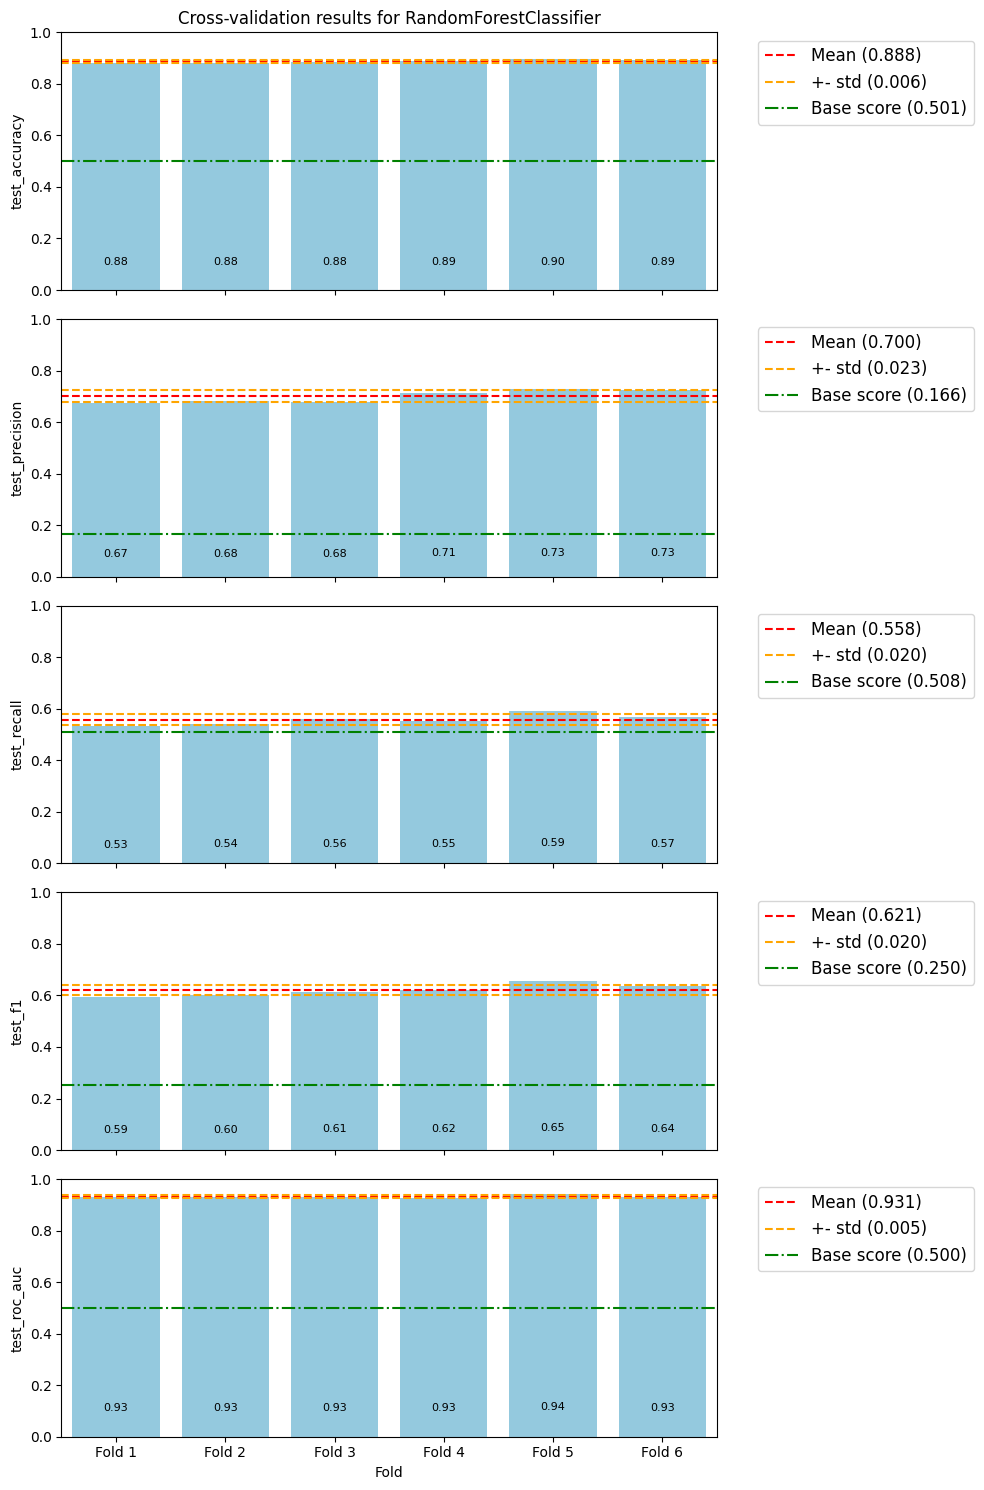

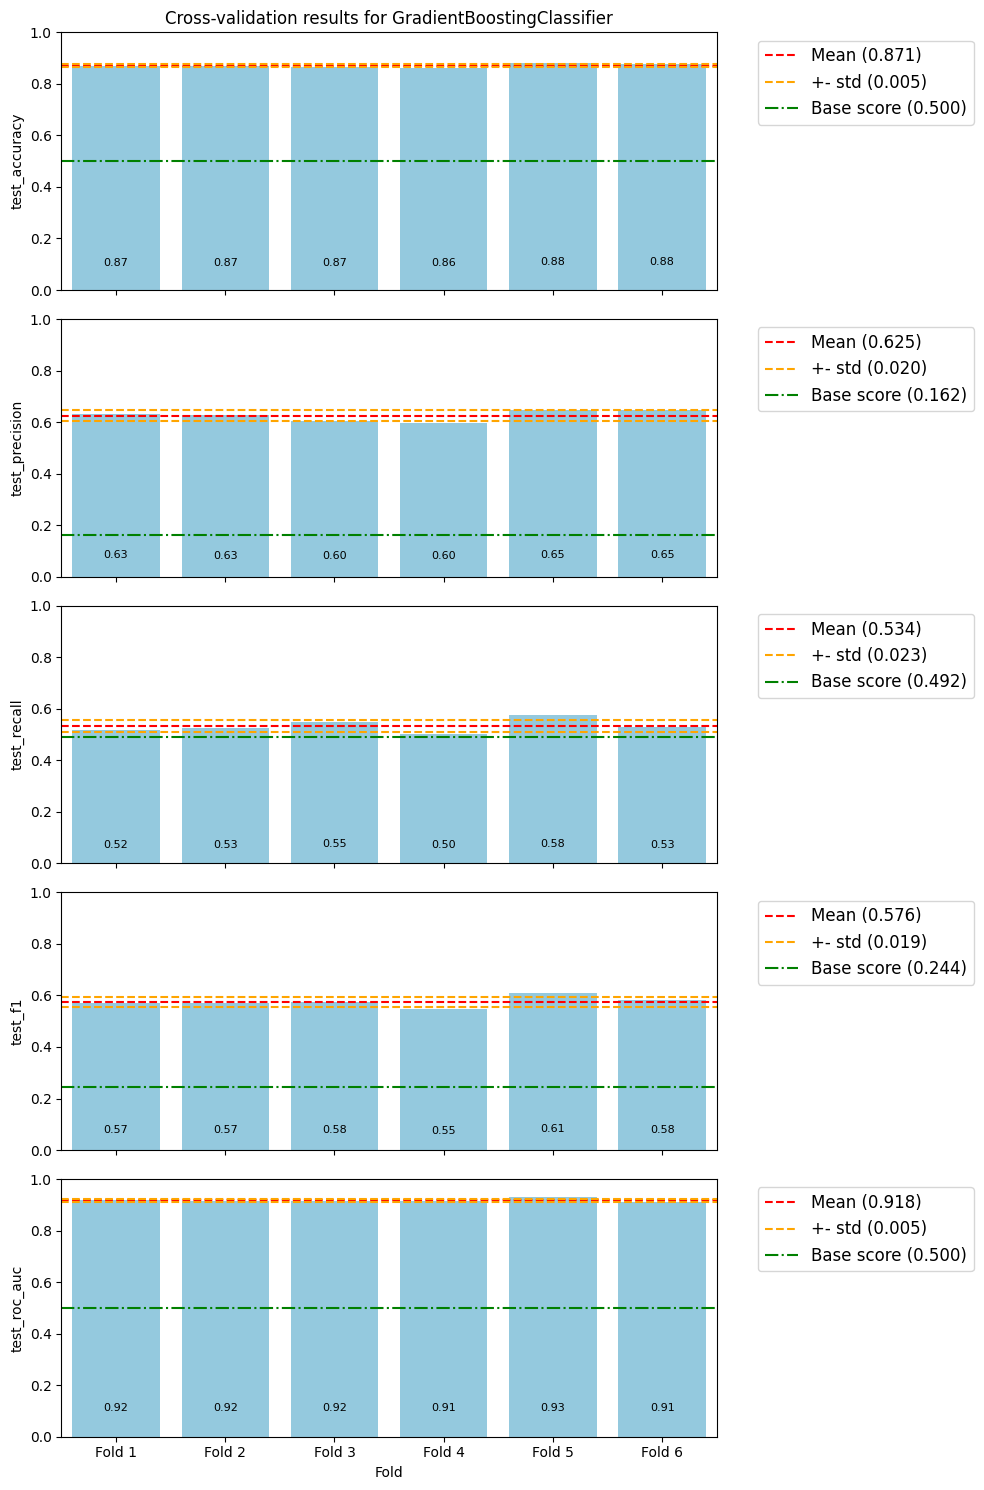

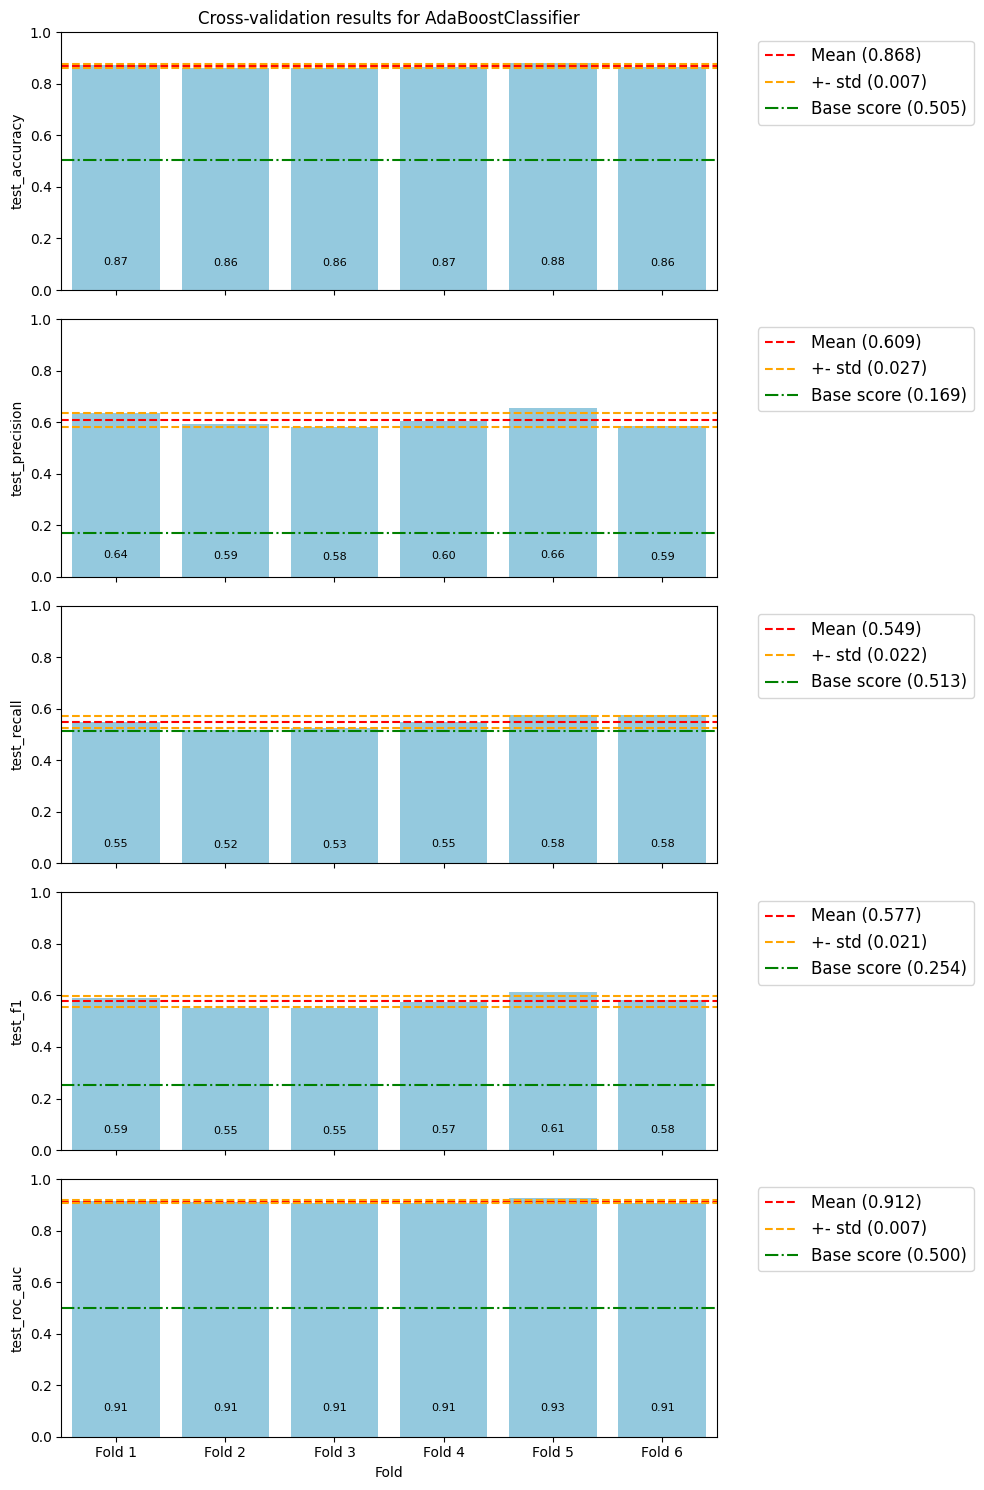

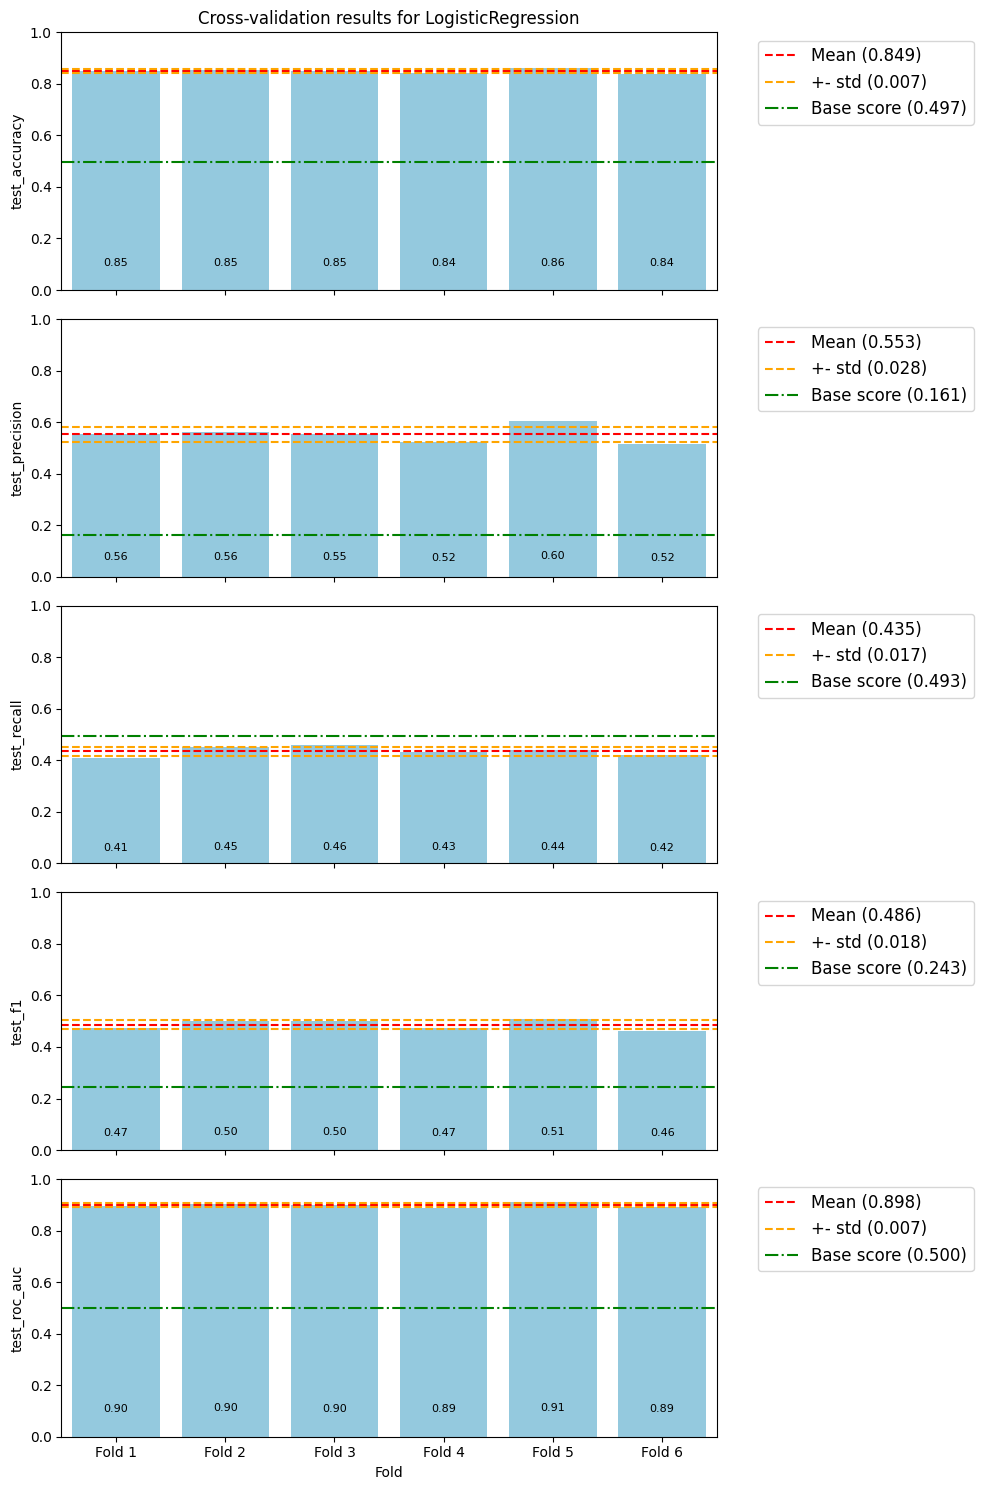

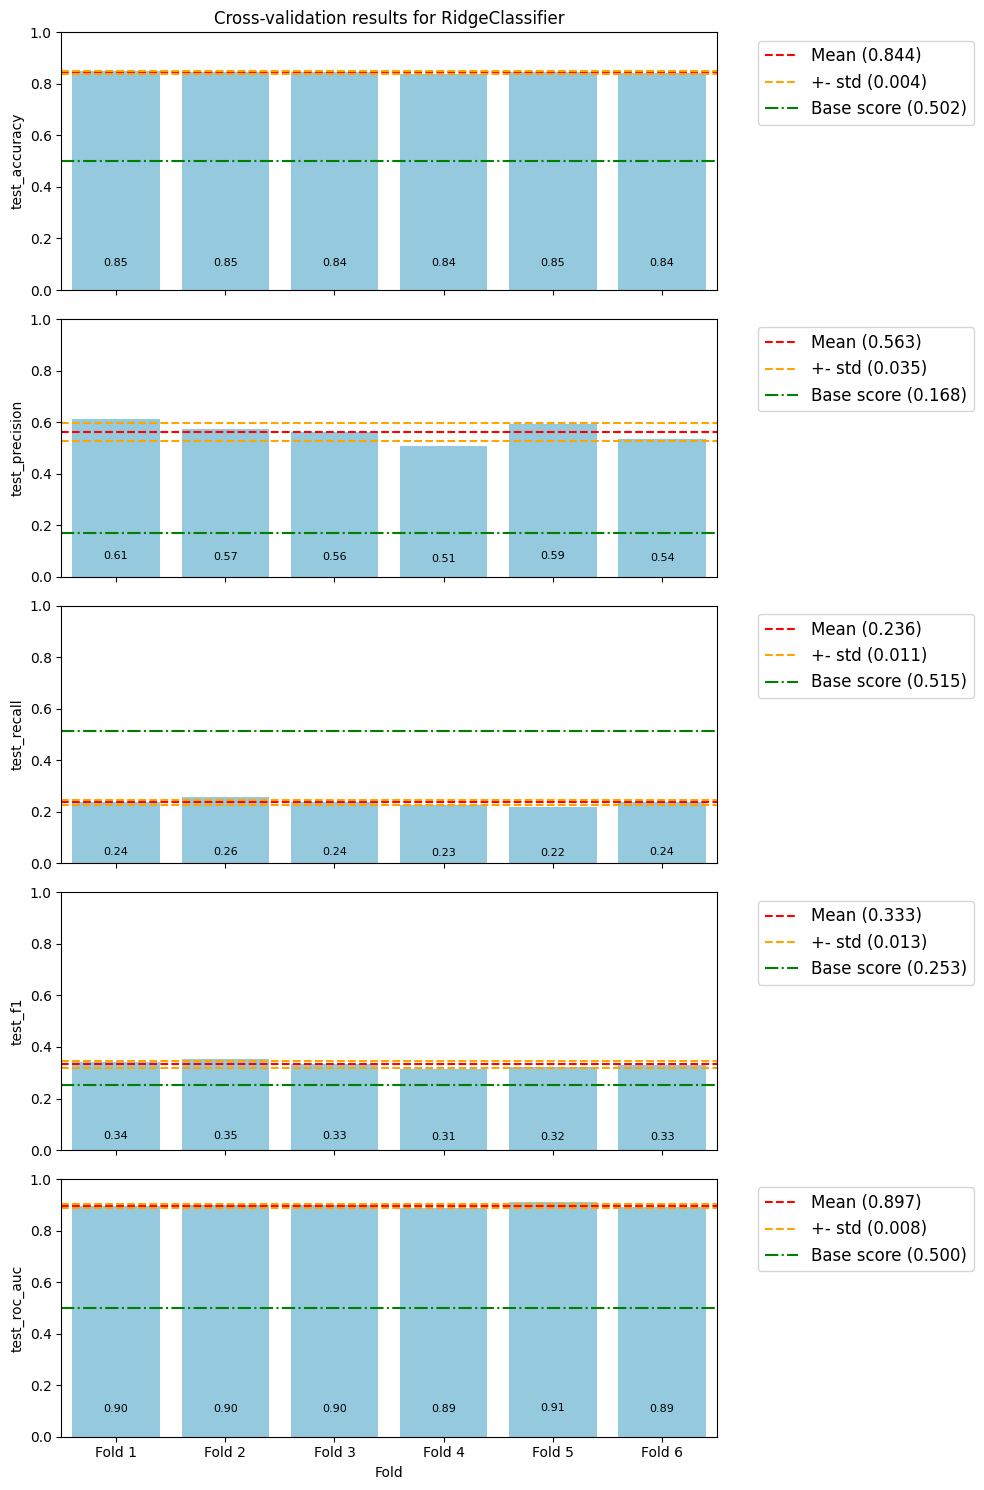

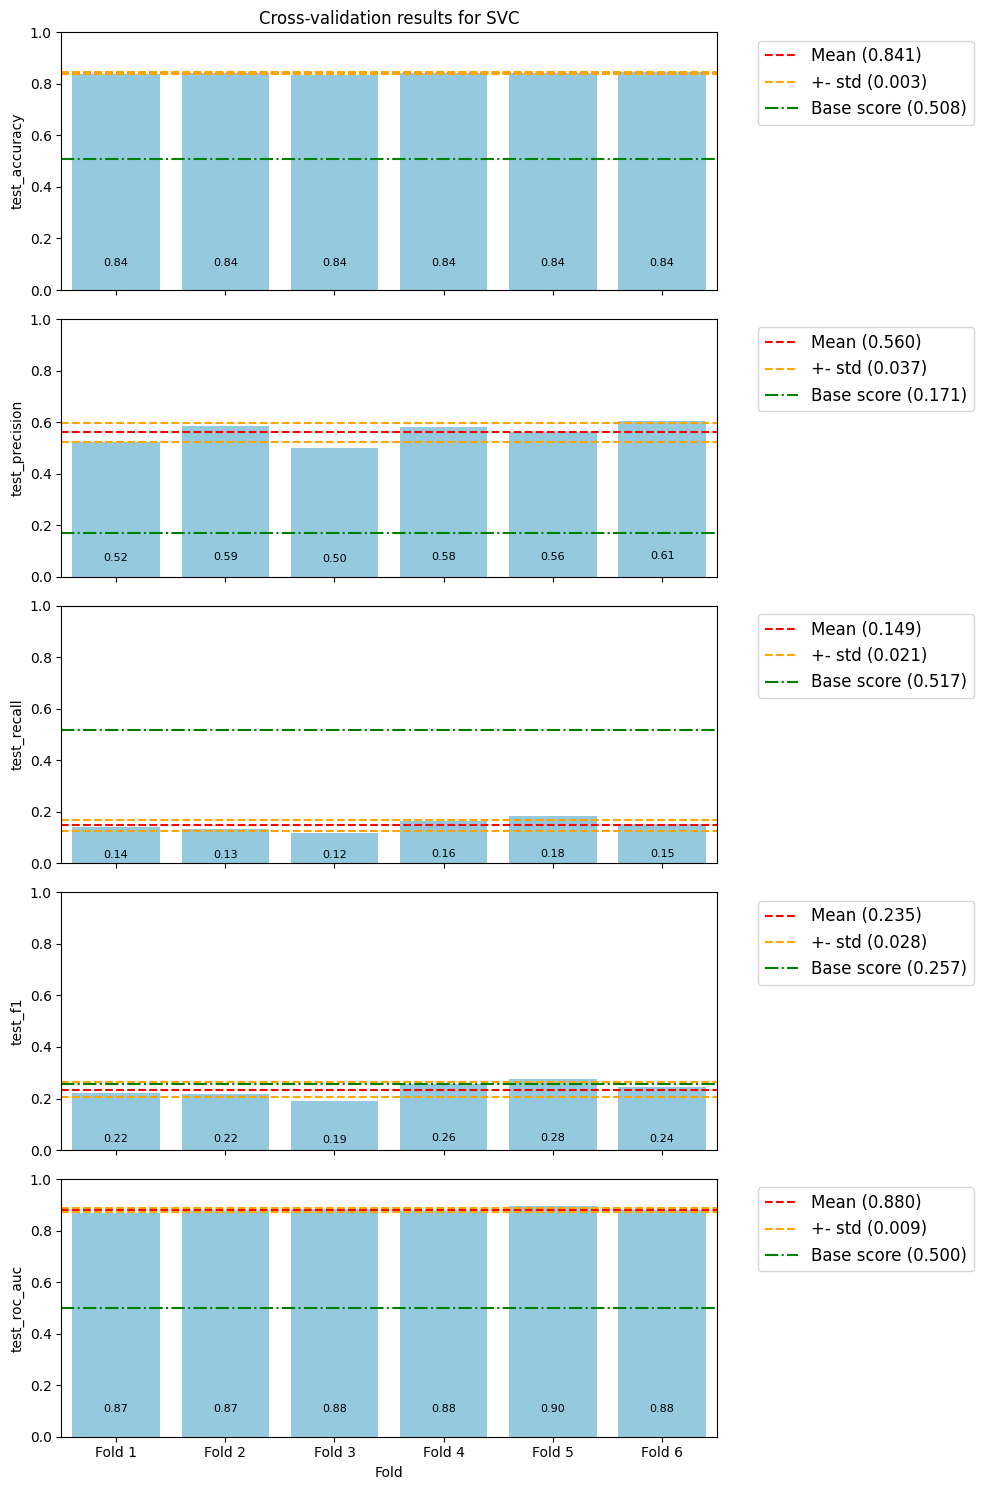

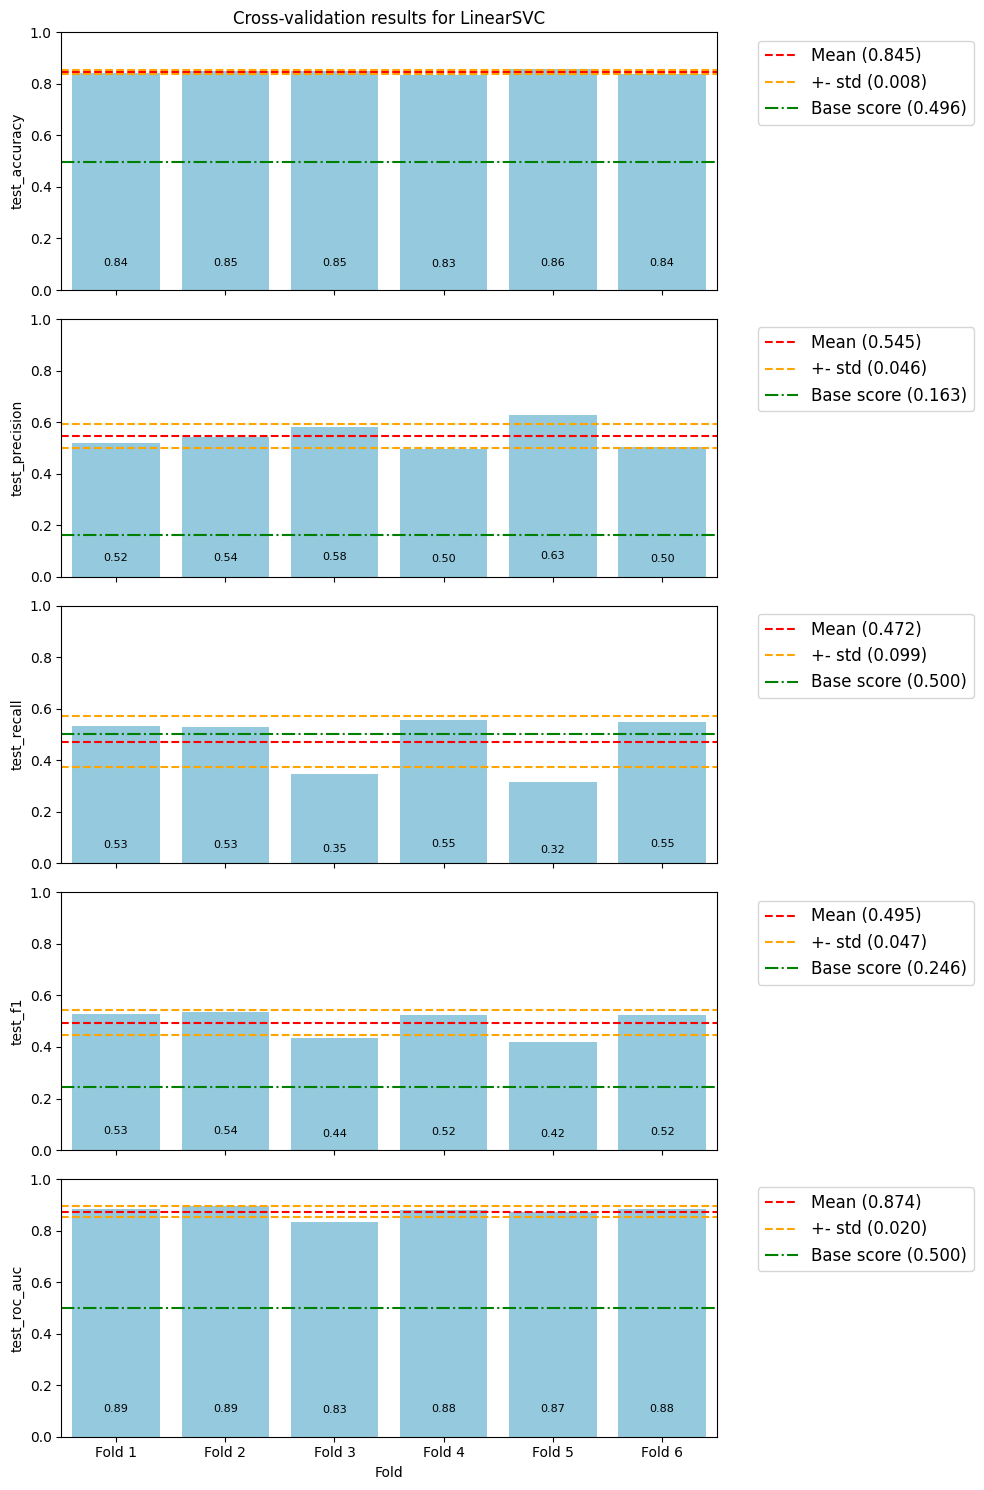

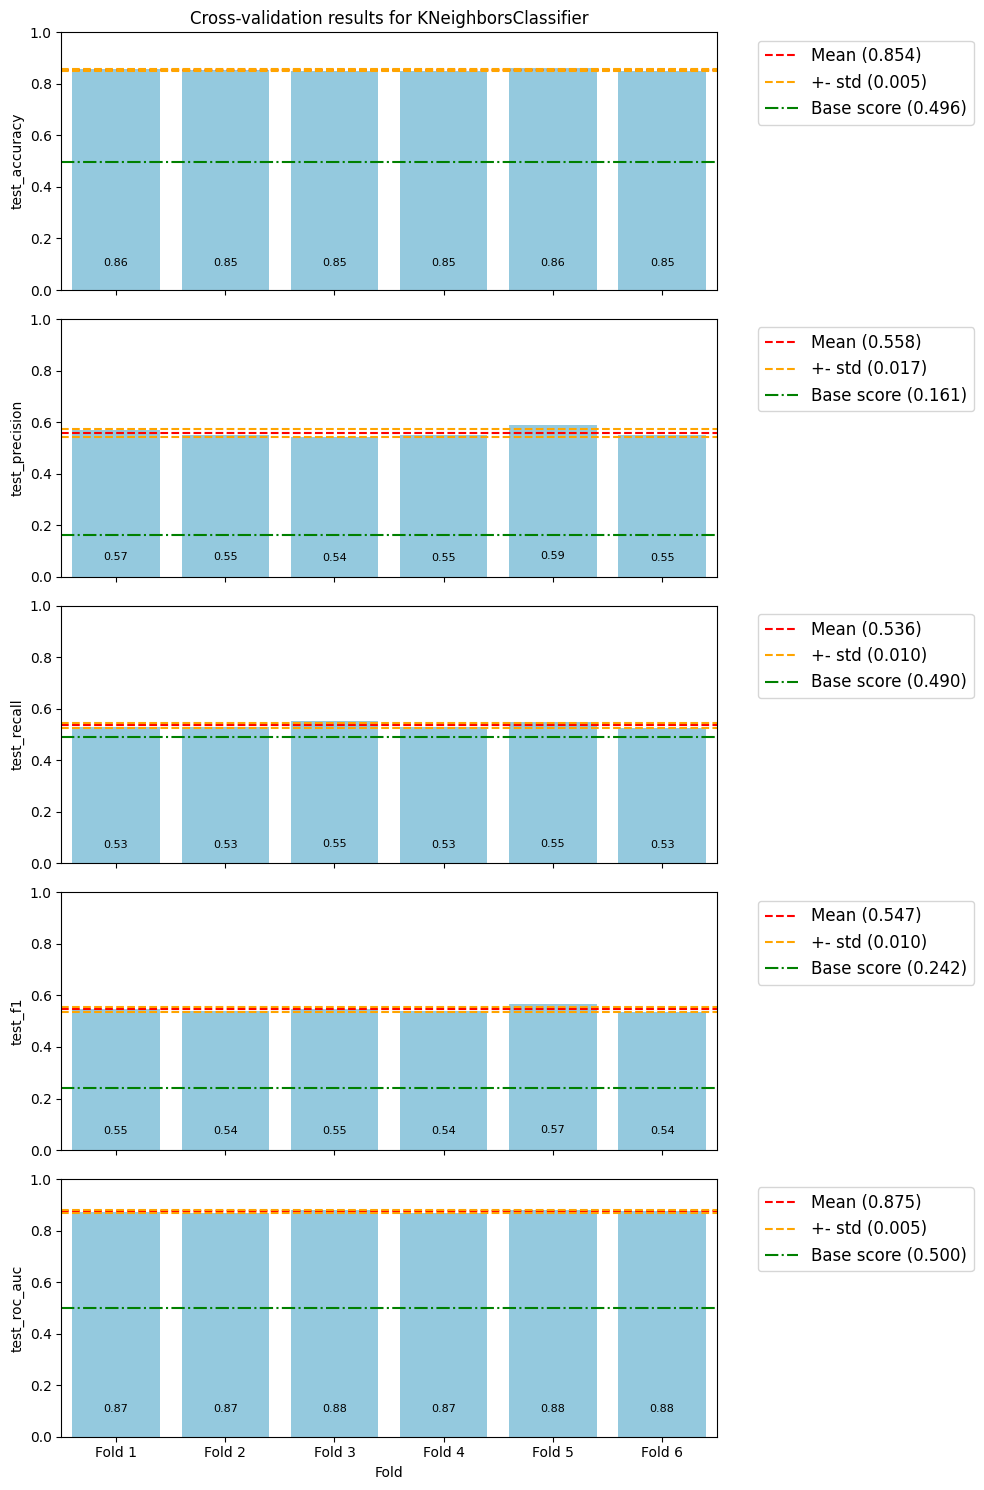

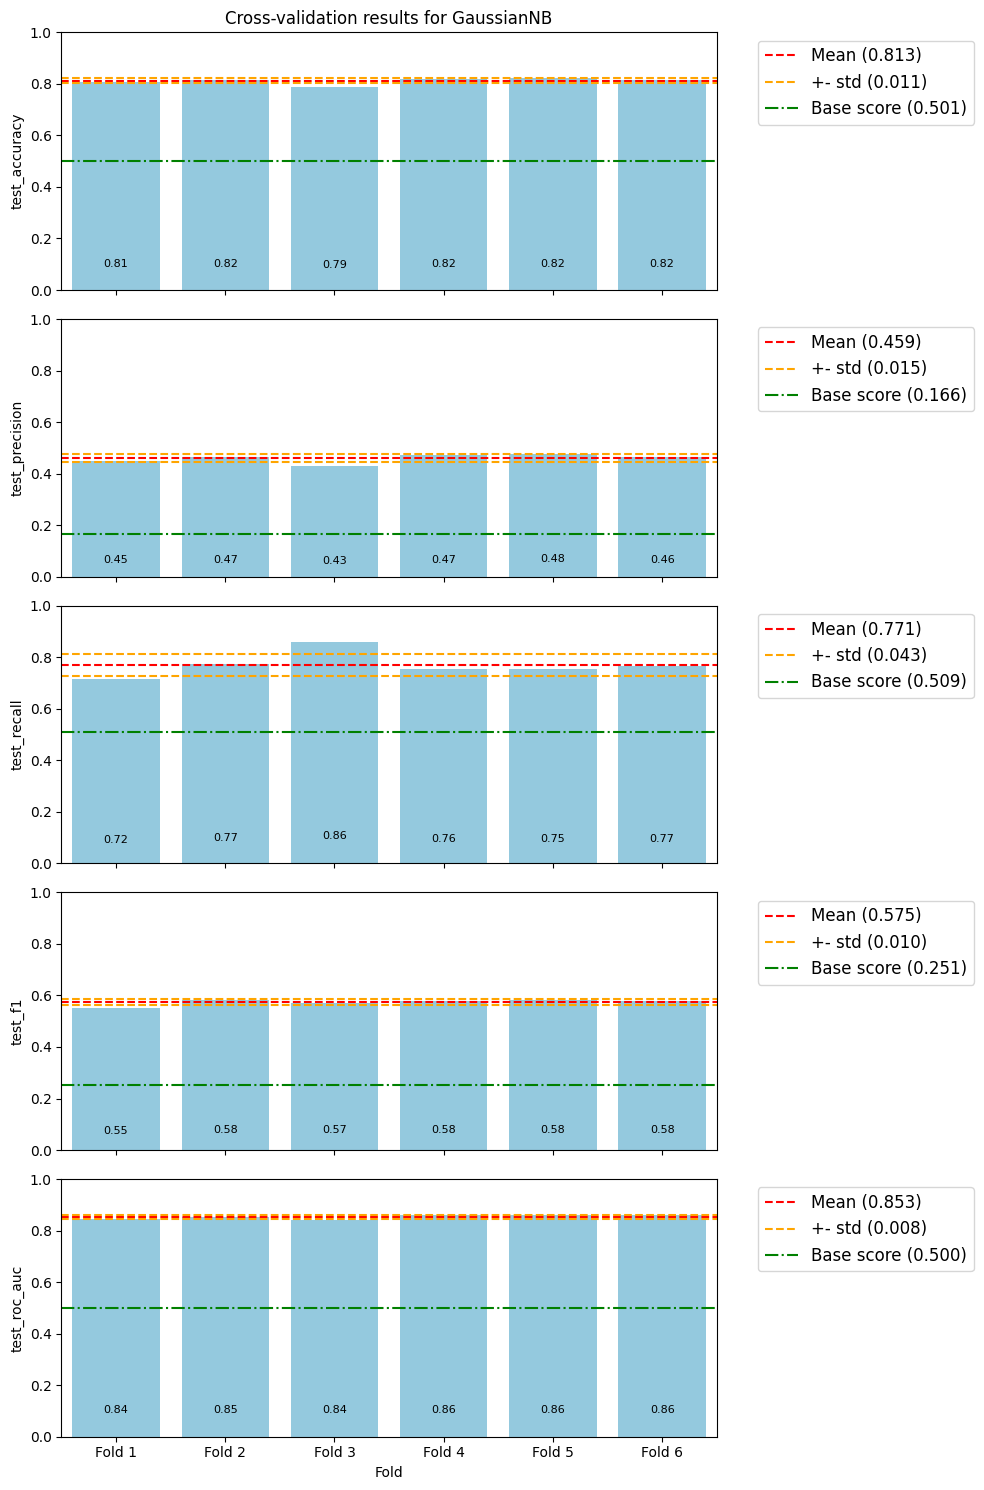

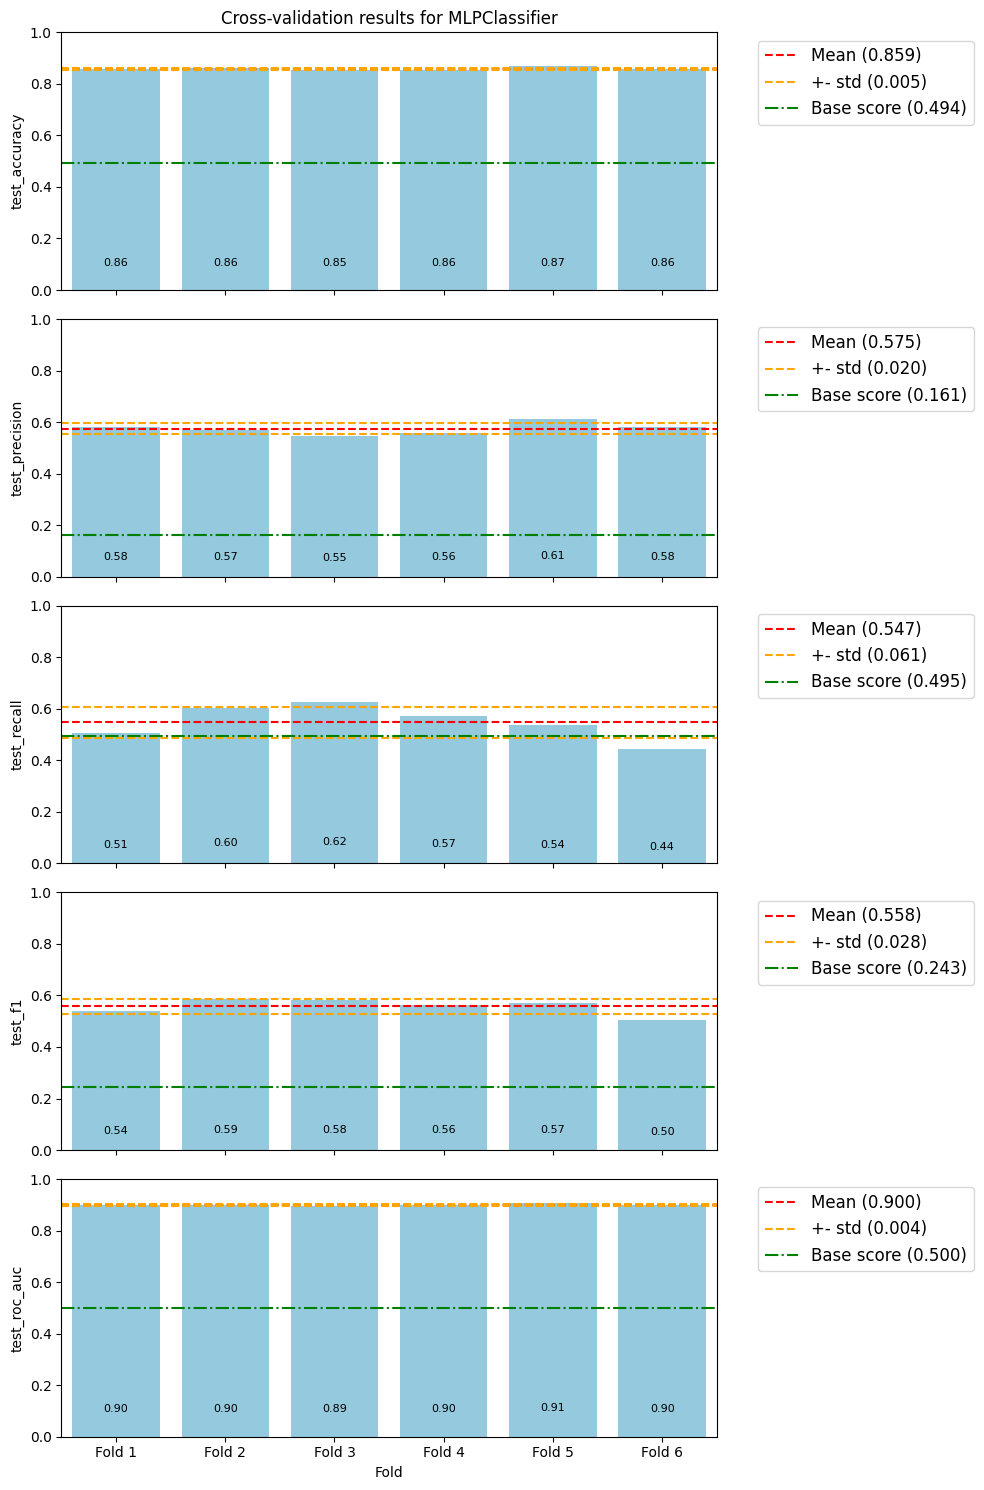

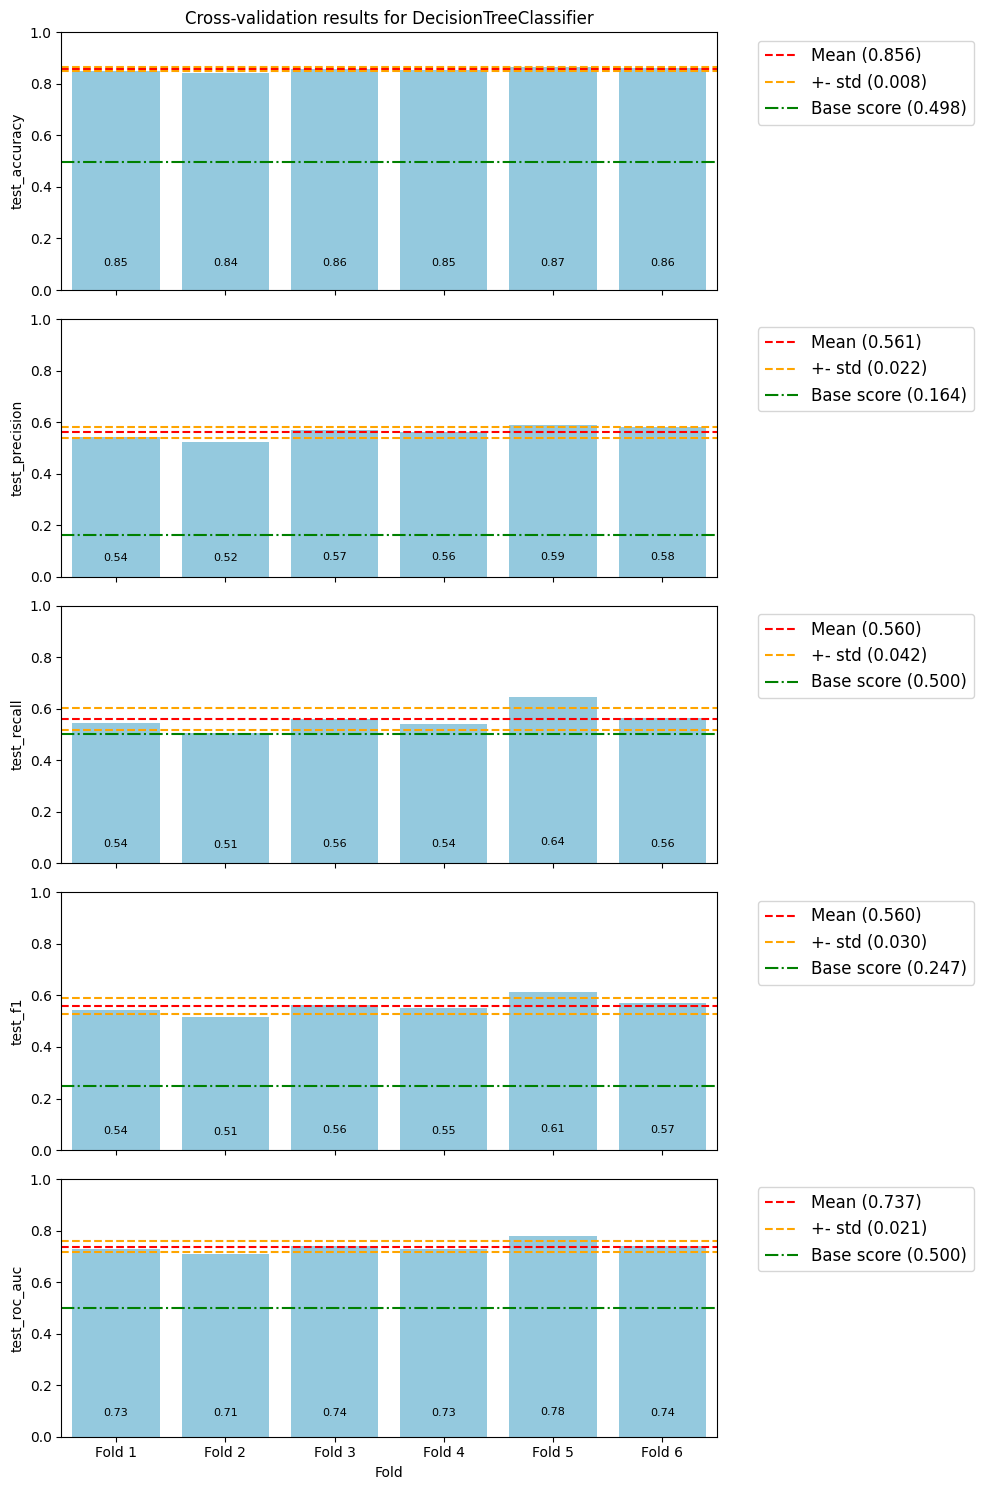

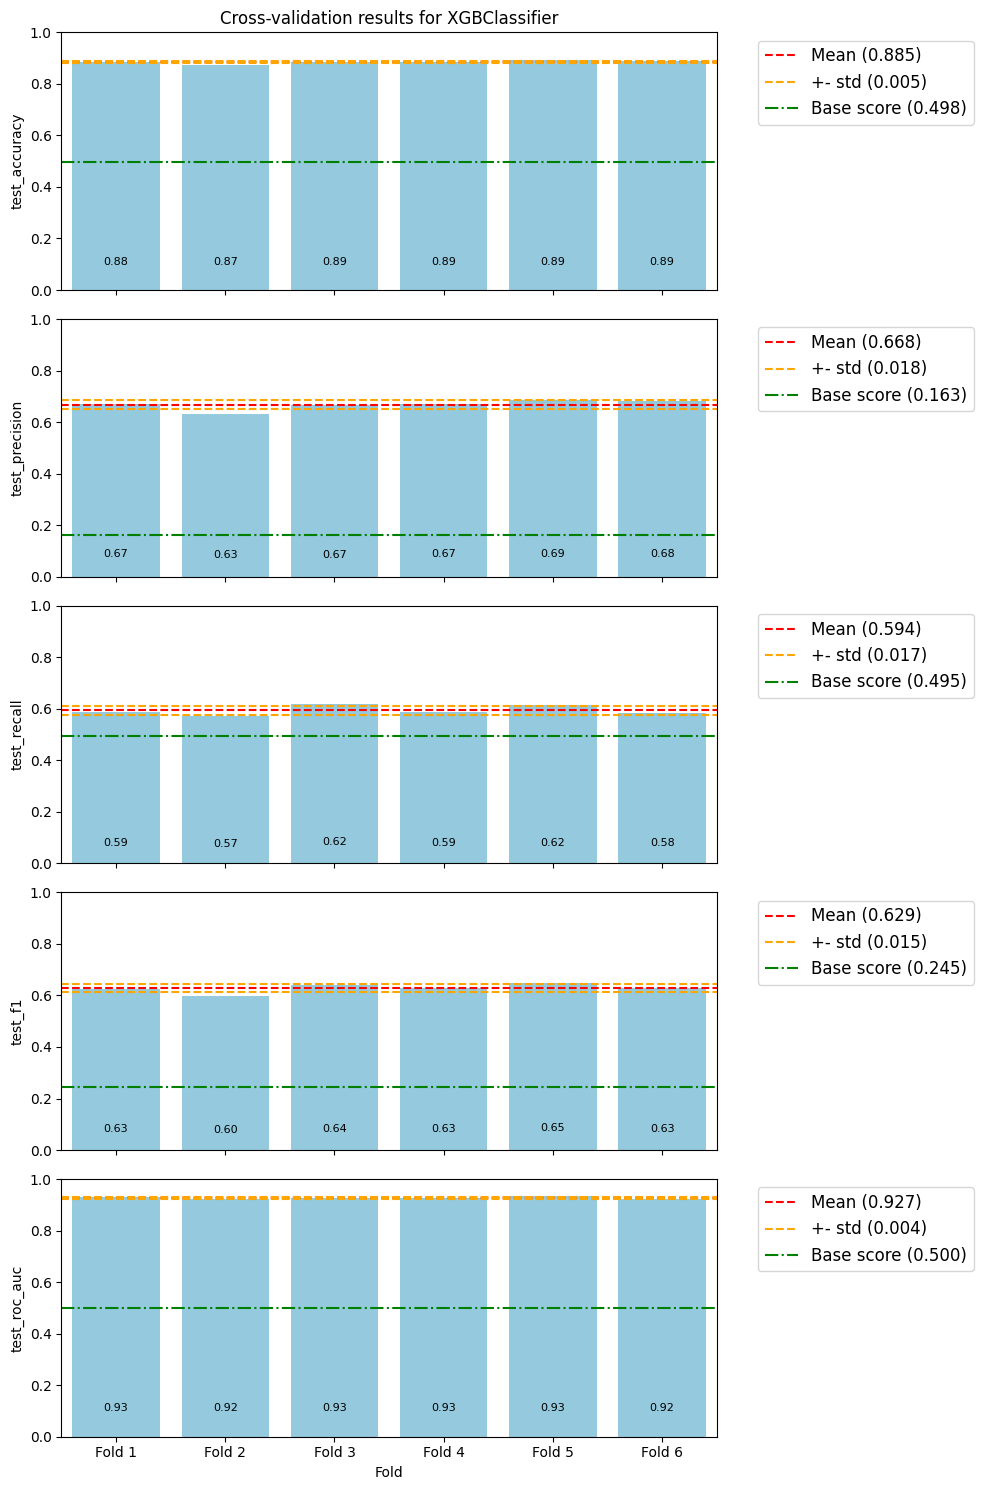

In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 

models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    LogisticRegression(),
    RidgeClassifier(),
    SVC(),
    LinearSVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(),
    DecisionTreeClassifier(),
    XGBClassifier()
]

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

scores = []
for model in models:
    scores.append(my_cross_validate(model, X_train, y_train, scoring=scoring))

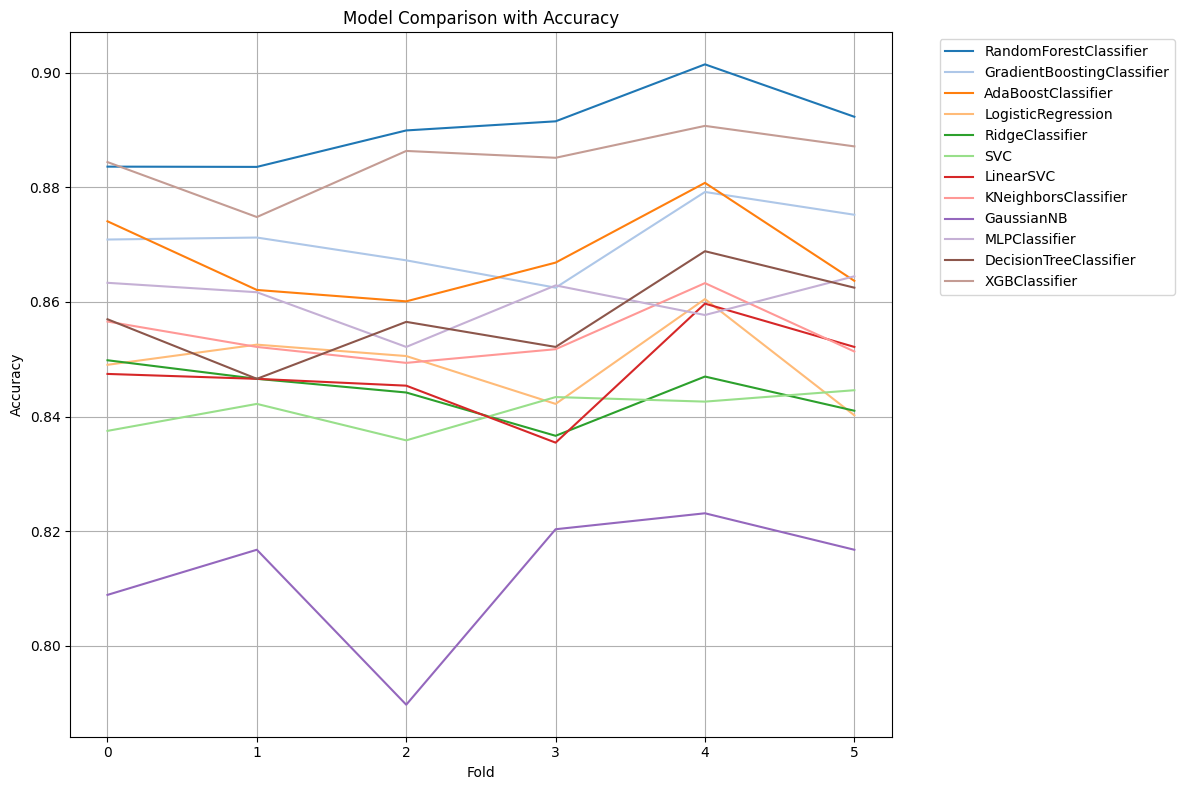

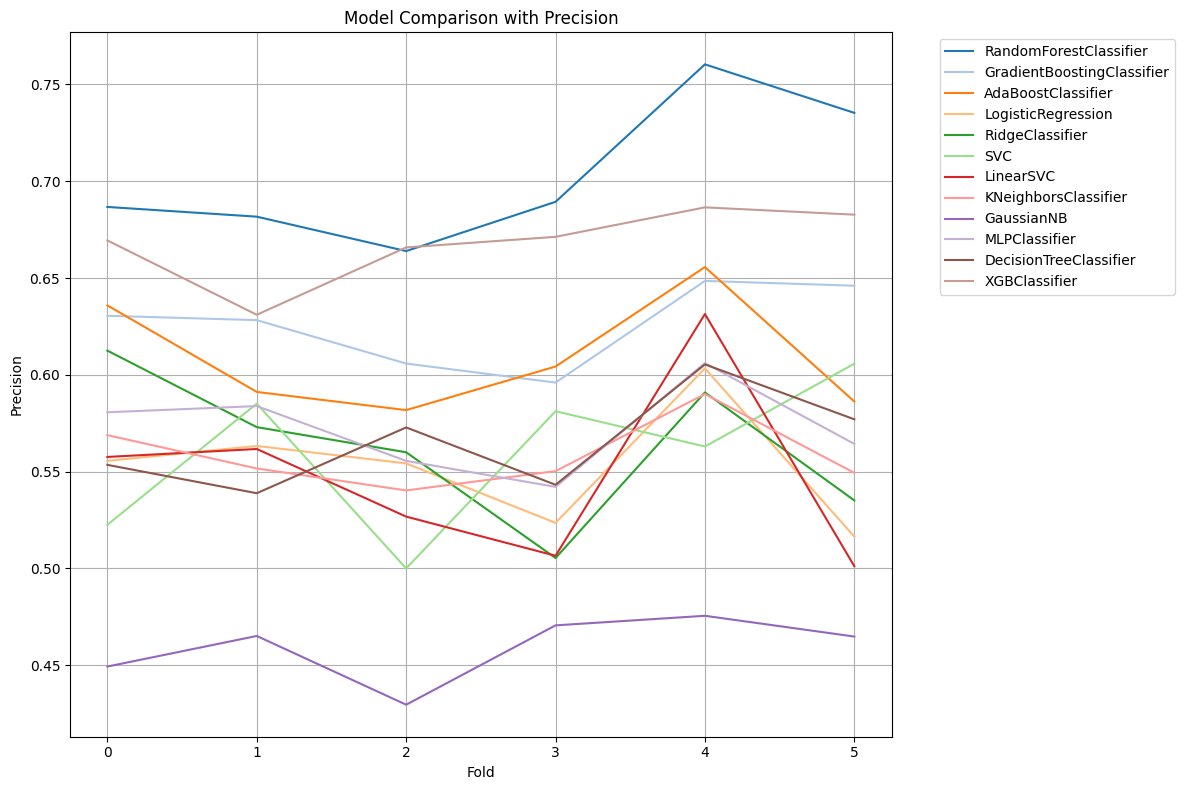

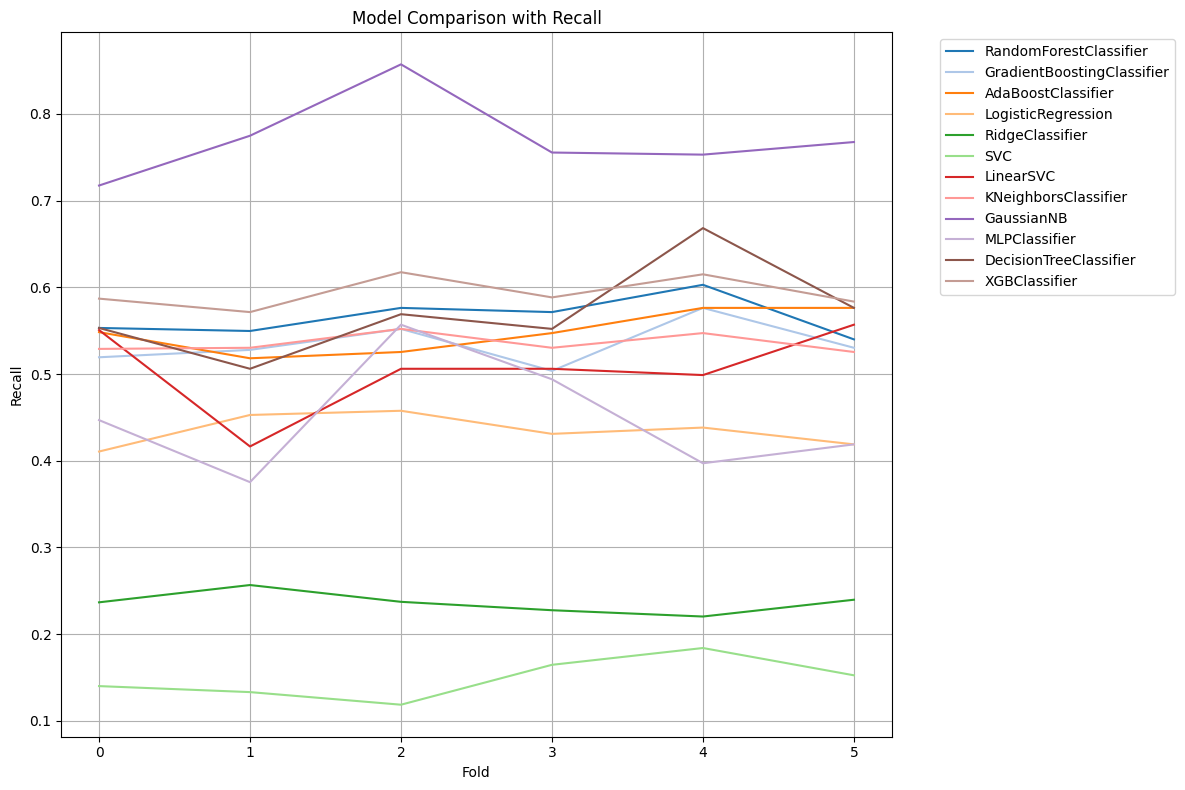

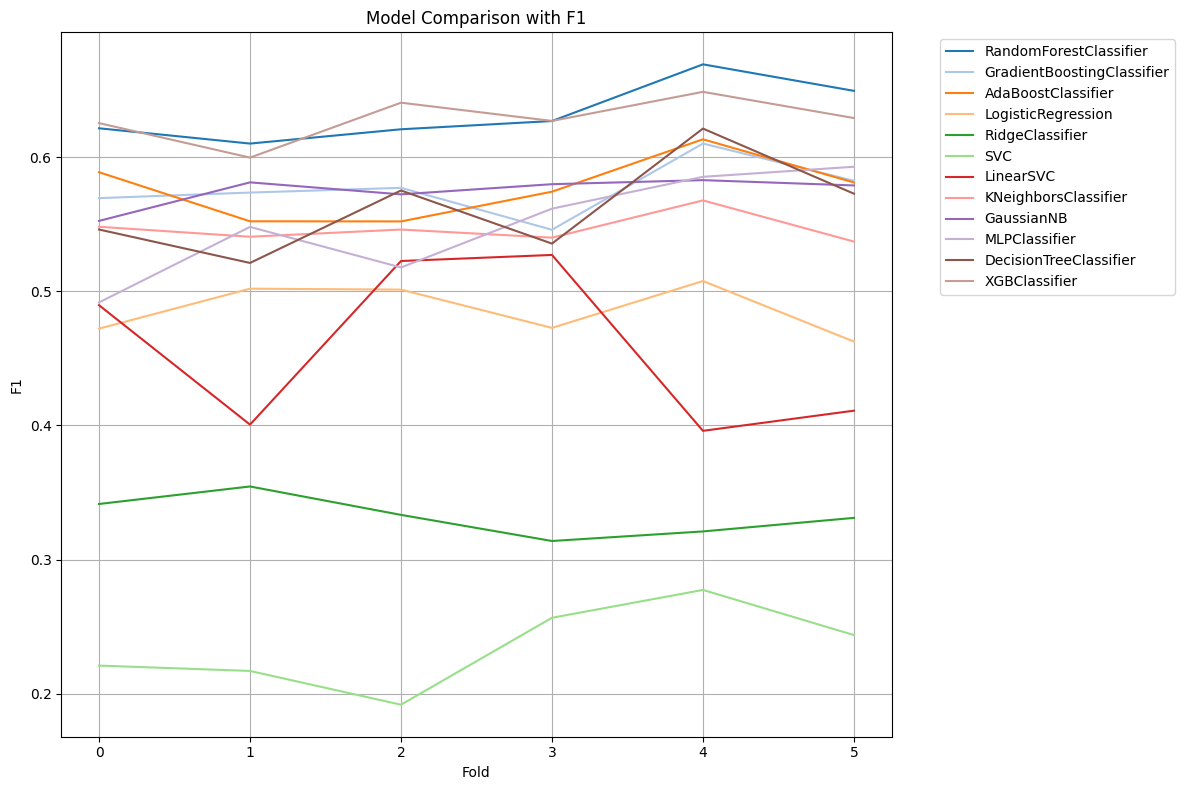

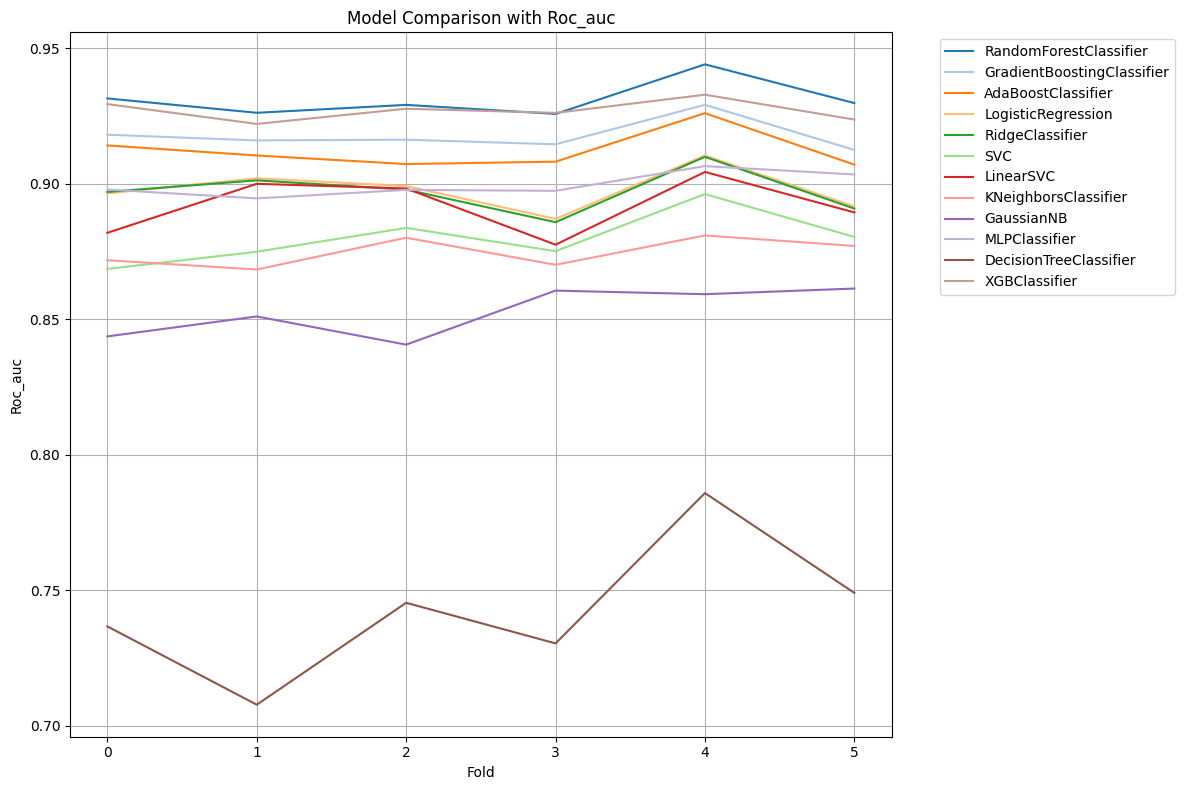

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

def my_cross_validate(models, X_train, y_train, cv=6, n_jobs=-1, scoring="f1"):
    all_scores = []
    dummy_model = DummyClassifier(strategy="uniform")  # Create a dummy classifier instance

    for model in models:
        # Cross-validate the model and dummy classifier
        model_cv_results = cross_validate(model, X_train, y_train, cv=cv, n_jobs=n_jobs, scoring=scoring)
        dummy_cv_results = cross_validate(dummy_model, X_train, y_train, cv=cv, n_jobs=n_jobs, scoring=scoring)

        # Extract model and dummy scores
        model_scores = {name: model_cv_results[name] for name in model_cv_results if name.startswith("test_")}
        dummy_scores = {name: dummy_cv_results[name] for name in dummy_cv_results if name.startswith("test_")}

        all_scores.append((model.__class__.__name__, model_scores, dummy_scores))

    return all_scores

def plot_model_comparison(scores, scoring):
    plt.figure(figsize=(12, 8))
    palette = sns.color_palette("tab20")
    sns.set_palette(palette)  # Explicitly set the palette
    for model_name, model_scores, _ in scores:
        for metric_name, metric_scores in model_scores.items():
            sns.lineplot(x=range(len(metric_scores)), y=metric_scores, label=f'{model_name}')

    plt.xlabel('Fold')
    plt.ylabel(scoring.capitalize())  # Capitalize the scoring metric for the plot
    plt.title(f'Model Comparison with {scoring.capitalize()}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define your models
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    LogisticRegression(),
    RidgeClassifier(),
    SVC(),
    LinearSVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(),
    DecisionTreeClassifier(),
    XGBClassifier()
]

# Define your scoring metrics
scorings = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# Example usage:
# Assuming X_train and y_train are defined
for scoring in scorings:
    scores = my_cross_validate(models, X_train, y_train, scoring=scoring)
    plot_model_comparison(scores, scoring)


In [6]:
# Initialize stratified k-fold
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# Initialize a variable to keep track of fold number
fold = 1

# Iterate over each fold
for train_index, test_index in kf.split(X_train, y_train):
    print('Fold {} of {}'.format(fold, kf.n_splits))
    
    # Split data into train and validation sets
    xtr, xvl = X_train.iloc[train_index], X_train.iloc[test_index]
    ytr, yvl = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Initialize and train the decision tree classifier
    model = DecisionTreeClassifier(random_state=1)
    model.fit(xtr, ytr)
    
    # Make predictions on the validation set
    pred_val = model.predict(xvl)
    
    # Calculate and print accuracy score
    score = accuracy_score(yvl, pred_val)
    print('Accuracy Score:', score)
    
    # Increment fold number
    fold += 1


NameError: name 'StratifiedKFold' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the random forest classifier on the entire training set
rf_model = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
rf_pred_val = rf_model.predict(X_val)

# Calculate accuracy score on the validation set
rf_val_score = accuracy_score(y_val, rf_pred_val)
print('Random Forest Validation Accuracy Score:', rf_val_score)


Random Forest Validation Accuracy Score: 0.8757341576506955


In [ ]:
# Initialize and train the decision tree classifier on the entire training set
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

# Make predictions on the validation set
pred_val = model.predict(X_val)

# Calculate accuracy score on the validation set
val_score = accuracy_score(y_val, pred_val)x
print('Validation Accuracy Score:', val_score)


Validation Accuracy Score: 0.8528593508500772


In [ ]:
# Initialize and train the decision tree classifier on the entire training set
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

# Make predictions on the validation set
pred_val = model.predict(X_val)

# Calculate accuracy score on the validation set
val_score = accuracy_score(y_val, pred_val)x
print('Validation Accuracy Score:', val_score)


Validation Accuracy Score: 0.8528593508500772


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression classifier on the entire training set
logistic_model = LogisticRegression(random_state=1)
logistic_model.fit(X_train, y_train)

# Make predictions on the validation set
logistic_pred_val = logistic_model.predict(X_val)

# Calculate accuracy score on the validation set
logistic_val_score = accuracy_score(y_val, logistic_pred_val)
print('Logistic Regression Validation Accuracy Score:', logistic_val_score)


Logistic Regression Validation Accuracy Score: 0.8537867078825347


In [ ]:
import xgboost as xgb

# Convert the DataFrame into DMatrix format (required for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',  # Use binary classification
    'eval_metric': 'error',           # Evaluate using classification error
    'seed': 1                         # Set random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 436  # Number of boosting rounds (you can tune this hyperparameter)
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the validation set
xgb_pred_val = xgb_model.predict(dval)
xgb_pred_val_binary = [1 if p > 0.5 else 0 for p in xgb_pred_val]

# Calculate accuracy score on the validation set
xgb_val_score = accuracy_score(y_val, xgb_pred_val_binary)
print('XGBoost Validation Accuracy Score:', xgb_val_score)

XGBoost Validation Accuracy Score: 0.887789799072643


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
xgb_conf_matrix = confusion_matrix(y_val, xgb_pred_val_binary)
xgb_conf_matrix
# Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('XGBoost Confusion Matrix')
# plt.show()


array([[2576,  158],
       [ 205,  296]], dtype=int64)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the Gradient Boosting Classifier on the entire training set
gb_model = GradientBoostingClassifier(random_state=1)
gb_model.fit(X_train, y_train)

# Make predictions on the validation set
gb_pred_val = gb_model.predict(X_val)

# Calculate accuracy score on the validation set
gb_val_score = accuracy_score(y_val, gb_pred_val)
print('Gradient Boosting Classifier Validation Accuracy Score:', gb_val_score)


Gradient Boosting Classifier Validation Accuracy Score: 0.8686244204018547


In [ ]:
# Training data
y_train = df['FINALIZED_LOAN']
X_train = df.drop(columns="FINALIZED_LOAN")

In [ ]:
# Initialize stratified k-fold
kf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# Initialize a variable to keep track of fold number
fold = 1

# Iterate over each fold
for train_index, test_index in kf.split(X_train, y_train):
    print('Fold {} of {}'.format(fold, kf.n_splits))
    
    # Split data into train and validation sets
    xtr, xvl = X_train.iloc[train_index], X_train.iloc[test_index]
    ytr, yvl = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Initialize and train the decision tree classifier
    model = RandomForestClassifier(random_state=1)
    model.fit(xtr, ytr)
    
    # Make predictions on the validation set
    pred_val = model.predict(xvl)
    
    # Calculate and print accuracy score
    score = accuracy_score(yvl, pred_val)
    print('Accuracy Score:', score)
    
    # Increment fold number
    fold += 1


Fold 1 of 10
Accuracy Score: 0.890728476821192
Fold 2 of 10
Accuracy Score: 0.8920529801324504
Fold 3 of 10
Accuracy Score: 0.8880794701986755
Fold 4 of 10
Accuracy Score: 0.8986754966887417
Fold 5 of 10
Accuracy Score: 0.8986754966887417
Fold 6 of 10
Accuracy Score: 0.8980132450331125
Fold 7 of 10
Accuracy Score: 0.8933774834437086
Fold 8 of 10
Accuracy Score: 0.8933068257123923
Fold 9 of 10
Accuracy Score: 0.8840291583830351
Fold 10 of 10
Accuracy Score: 0.8913187541418157


In [ ]:
# Initialize stratified k-fold
kf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# Initialize a variable to keep track of fold number
fold = 1

# Iterate over each fold
for train_index, test_index in kf.split(X_train, y_train):
    print('Fold {} of {}'.format(fold, kf.n_splits))
    
    # Split data into train and validation sets
    xtr, xvl = X_train.iloc[train_index], X_train.iloc[test_index]
    ytr, yvl = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Initialize and train the decision tree classifier
    model = RandomForestClassifier(random_state=1)
    model.fit(xtr, ytr)
    
    # Make predictions on the validation set
    pred_val = model.predict(xvl)
    
    # Calculate and print accuracy score
    score = f1_score(yvl, pred_val)
    print('Accuracy Score:', score)
    
    # Increment fold number
    fold += 1

NameError: name 'StratifiedKFold' is not defined